## Prediction of store sales

In [1]:
import sys
import pandas as pd
sys.path.append('../scripts')
from data_preprocessing import load_data
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging

In [2]:
# Initialize logger
logging.basicConfig(filename='../logs/prediction.log', level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s')

In [3]:
test_file_path = '../data/test.csv'
train_file_path = '../data/train.csv'
store_file_path = '../data/store.csv'

In [4]:
test_df=load_data(test_file_path)
train_df=load_data(train_file_path)
store_df=load_data(store_file_path)

c:\Users\zelalem.wubet\projects\personal\ten-academy\Sales_Forcasting_Rossmann_Pharmaceuticals\notebooks\../scripts\data_preprocessing.py:14: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


In [5]:
train_df  = train_df.merge(store_df, how='left', on='Store')
test_df = test_df.merge(store_df, how='left', on='Store')

In [6]:
train_df['Date'] = pd.to_datetime(train_df.Date)
test_df['Date'] = pd.to_datetime(test_df.Date)

## Preprocessing

#### Extract Features from Datetime Columns

In [7]:
# Extracting features from date
train_df['Day'] = train_df['Date'].dt.day
train_df['Weekday'] = train_df['Date'].dt.weekday
train_df['IsWeekend'] = train_df['Weekday'] >= 5
train_df['Month'] = train_df['Date'].dt.month
train_df['IsBeginningOfMonth'] = train_df['Day'] <= 10
train_df['IsMidMonth'] = (train_df['Day'] > 10) & (train_df['Day'] <= 20)
train_df['IsEndOfMonth'] = train_df['Day'] > 20
train_df['Year'] = train_df.Date.dt.year

In [8]:
test_df['Day'] = test_df.Date.dt.day
test_df['Month'] = test_df.Date.dt.month
test_df['Year'] = test_df.Date.dt.year

In [9]:
train_size = int(.75 * len(train_df))
train_size

762906

In [10]:
sorted_df = train_df.sort_values('Date')
train_df, val_df = sorted_df[:train_size], sorted_df[train_size:]

In [11]:
len(train_df), len(val_df)

(762906, 254303)

In [12]:
train_df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Day', 'Weekday', 'IsWeekend',
       'Month', 'IsBeginningOfMonth', 'IsMidMonth', 'IsEndOfMonth', 'Year'],
      dtype='object')

In [13]:
input_cols = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'StoreType', 'Assortment', 'Day', 'Month', 'Year']

In [14]:
target_col = 'Sales'

In [15]:
train_df['StateHoliday'] = train_df['StateHoliday'].astype(str)
unique_values = train_df['StateHoliday'].unique()
print(unique_values)


['a' '0' 'b' 'c']


C:\Users\zelalem.wubet\AppData\Local\Temp\ipykernel_18196\1549473152.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['StateHoliday'] = train_df['StateHoliday'].astype(str)


In [16]:
train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()

In [17]:
val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()

In [18]:
numeric_cols = ['Store', 'Day', 'Month', 'Year']
categorical_cols = ['DayOfWeek', 'Promo', 'StateHoliday', 'StoreType', 'Assortment']

In [19]:
test_inputs = test_df[input_cols].copy()

In [20]:
from sklearn.impute import SimpleImputer

In [21]:
imputer = SimpleImputer(strategy='mean').fit(train_inputs[numeric_cols])

In [22]:
train_inputs[numeric_cols] = imputer.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = imputer.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = imputer.transform(test_inputs[numeric_cols])

In [23]:
from sklearn.preprocessing import MinMaxScaler

In [24]:
scaler = MinMaxScaler().fit(train_inputs[numeric_cols])

In [25]:
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

In [26]:
from sklearn.preprocessing import OneHotEncoder

In [27]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit(train_inputs[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))

In [28]:
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

In [29]:
X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

In [54]:
encoded_cols

['DayOfWeek_1',
 'DayOfWeek_2',
 'DayOfWeek_3',
 'DayOfWeek_4',
 'DayOfWeek_5',
 'DayOfWeek_6',
 'DayOfWeek_7',
 'Promo_0',
 'Promo_1',
 'StateHoliday_0',
 'StateHoliday_a',
 'StateHoliday_b',
 'StateHoliday_c',
 'StoreType_a',
 'StoreType_b',
 'StoreType_c',
 'StoreType_d',
 'Assortment_a',
 'Assortment_b',
 'Assortment_c']

In [30]:
def return_mean(inputs):
    return np.full(len(inputs), train_df.Sales.mean())

In [31]:
train_preds = return_mean(X_train)

In [32]:
train_preds

array([5720.63337161, 5720.63337161, 5720.63337161, ..., 5720.63337161,
       5720.63337161, 5720.63337161])

In [33]:
from sklearn.metrics import mean_squared_error

In [34]:
mean_squared_error(train_preds, train_targets, squared=False)

c:\Users\zelalem.wubet\projects\personal\ten-academy\Sales_Forcasting_Rossmann_Pharmaceuticals\venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


np.float64(3806.057154301672)

In [35]:
mean_squared_error(return_mean(X_val), val_targets, squared=False)

c:\Users\zelalem.wubet\projects\personal\ten-academy\Sales_Forcasting_Rossmann_Pharmaceuticals\venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


np.float64(3980.045927630948)

In [36]:
from sklearn.linear_model import LinearRegression

In [37]:
linreg = LinearRegression()

In [38]:
linreg.fit(X_train, train_targets)

LinearRegression()

In [39]:
train_preds = linreg.predict(X_train)
train_preds

array([ -563.125, -1242.25 ,  -312.25 , ...,  5647.375,  6273.625,
        5950.5  ])

In [40]:
mean_squared_error(train_preds, train_targets, squared=False)

c:\Users\zelalem.wubet\projects\personal\ten-academy\Sales_Forcasting_Rossmann_Pharmaceuticals\venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


np.float64(2566.0028976914186)

In [41]:
val_preds = linreg.predict(X_val)
val_preds

array([5950.375, 6273.375, 5833.75 , ..., 7647.125, 8273.25 , 7780.875])

In [42]:
mean_squared_error(val_preds, val_targets, squared=False)

c:\Users\zelalem.wubet\projects\personal\ten-academy\Sales_Forcasting_Rossmann_Pharmaceuticals\venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


np.float64(2618.340879139643)

In [43]:
def try_model(model):
    # Fit the model
    model.fit(X_train, train_targets)

    # Generate predictions
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val)

    # Compute RMSE
    train_rmse = mean_squared_error(train_targets, train_preds, squared=False)
    val_rmse = mean_squared_error(val_targets, val_preds, squared=False)
    return train_rmse, val_rmse

In [44]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor

In [45]:
try_model(LinearRegression())

c:\Users\zelalem.wubet\projects\personal\ten-academy\Sales_Forcasting_Rossmann_Pharmaceuticals\venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\zelalem.wubet\projects\personal\ten-academy\Sales_Forcasting_Rossmann_Pharmaceuticals\venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


(np.float64(2566.0028976914186), np.float64(2618.340879139643))

In [46]:
try_model(Ridge())

c:\Users\zelalem.wubet\projects\personal\ten-academy\Sales_Forcasting_Rossmann_Pharmaceuticals\venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\zelalem.wubet\projects\personal\ten-academy\Sales_Forcasting_Rossmann_Pharmaceuticals\venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


(np.float64(2566.001786748527), np.float64(2618.3462538767744))

In [47]:
try_model(Lasso())


c:\Users\zelalem.wubet\projects\personal\ten-academy\Sales_Forcasting_Rossmann_Pharmaceuticals\venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\zelalem.wubet\projects\personal\ten-academy\Sales_Forcasting_Rossmann_Pharmaceuticals\venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


(np.float64(2566.269842224304), np.float64(2619.1654376249758))

In [48]:
try_model(ElasticNet())

c:\Users\zelalem.wubet\projects\personal\ten-academy\Sales_Forcasting_Rossmann_Pharmaceuticals\venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\zelalem.wubet\projects\personal\ten-academy\Sales_Forcasting_Rossmann_Pharmaceuticals\venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


(np.float64(3246.772285115263), np.float64(3413.81266815479))

In [49]:
try_model(SGDRegressor())

c:\Users\zelalem.wubet\projects\personal\ten-academy\Sales_Forcasting_Rossmann_Pharmaceuticals\venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\zelalem.wubet\projects\personal\ten-academy\Sales_Forcasting_Rossmann_Pharmaceuticals\venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


(np.float64(2568.0728824328485), np.float64(2630.8395530226508))

In [50]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

In [51]:
tree = DecisionTreeRegressor(random_state=42)
try_model(tree)

c:\Users\zelalem.wubet\projects\personal\ten-academy\Sales_Forcasting_Rossmann_Pharmaceuticals\venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\zelalem.wubet\projects\personal\ten-academy\Sales_Forcasting_Rossmann_Pharmaceuticals\venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


(np.float64(0.0), np.float64(1481.4843380060588))

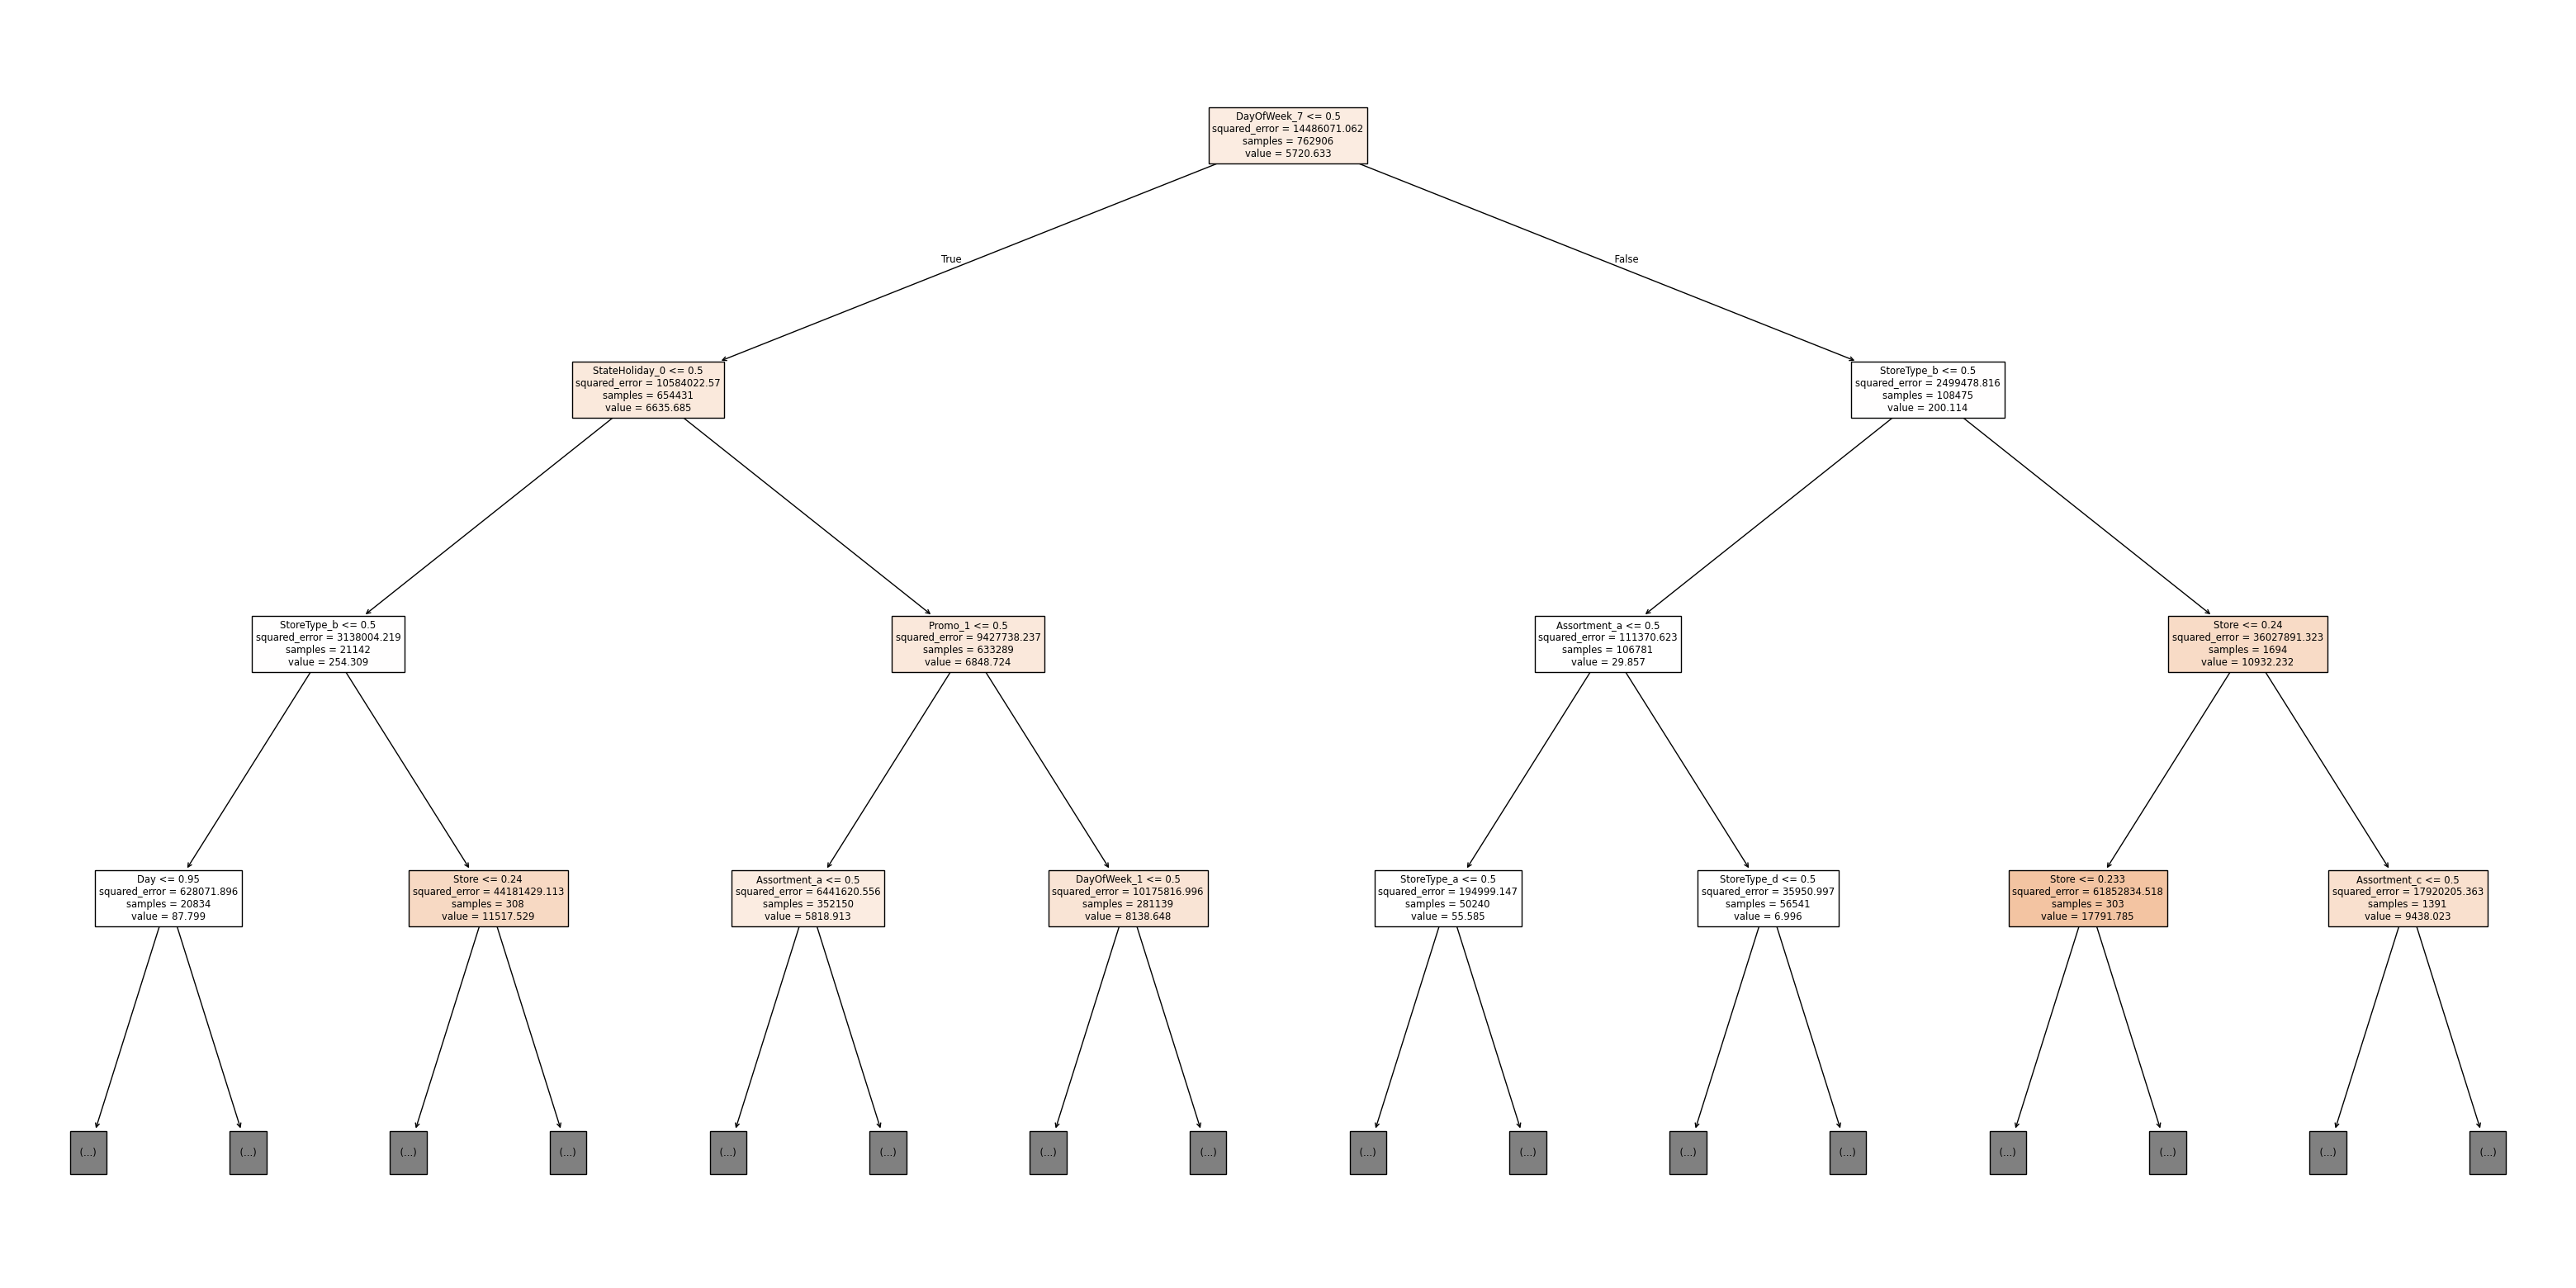

In [52]:
plt.figure(figsize=(40, 20))
plot_tree(tree, max_depth=3, filled=True, feature_names=numeric_cols+encoded_cols);